# Sentiment analysis algorithms

## TF-IDF and Support Vector Classification

While no information on model implementation requirements is provided, in practice, the model is unable to load and perform inference with the latest version of the scikit-learn. Different scikit-learn version testing shows the model to be created with **scikit-learn 0.23.2** version. 

Therefore, it is first necessary to install this particular version of scikit-learn to access the model. 

In [1]:
!pip install scikit-learn==0.23.2

     |████████████████████████████████| 6.8MB 7.9MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


Next, we load the model and take a look at its `Pipeline`.

In [2]:
from joblib import load

In [3]:
clf_pipe = load('/content/sentiment_pipe.joblib')

We notice that the current sentiment analysis model uses TF-IDF and Support Vector Classification.

In [ ]:
clf_pipe

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=1000, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_fun

### Current model performances

No test dataset was provided, thus in order to be able to test the model performance, we have find out on which kind of data it performs sentiment analysis. A quick look at `comments_train.csv` reveals that the model was trained to analyse the restaurant reviews.

In [4]:
import pandas as pd

In [5]:
train_data = pd.read_csv('/content/comments_train.csv')

In [6]:
train_data.head()

,comment,sentiment
0,J'ai réservé ma table quelques mois à l'avance...,Positive
1,Que dire... Nicolas sale est un chef d excepti...,Positive
2,Dans une rue tranquille non loin du Panthéon u...,Positive
3,Rien à redire le restaurant est irréprochablem...,Positive
4,Comme avec les autres commentaires nos repas é...,Positive


In [7]:
train_data.shape

(1617, 2)

In [8]:
train_data.groupby(['sentiment']).count()

,comment
sentiment,
Negative,598
Positive,1019


We thus compile a custom test dataset of restaurant reviews and their respective sentiment.

This dataset consists of **50 reviews**, of which 24 are labeled as *'Negative'* and 26 are labeled as *'Positive'*.

In [7]:
test_data = pd.read_csv('/content/comments_test.csv')

In [8]:
test_data.head()

,comment,sentiment
0,Le pire restaurant de ma vie !!! Plats immange...,Negative
1,Vous pouvez comparer les plats à des plats pro...,Negative
2,Nous avons déjeuner sur le pouce en terrasse d...,Positive
3,Super café emplacement idéal prix tout à fait ...,Positive
4,Nettoyage des tables en option serveurs extrêm...,Negative


In [10]:
test_data.shape

(50, 2)

In [13]:
test_data.groupby(['sentiment']).count()

,comment
sentiment,
Negative,24
Positive,26


Furtheron, we apply some data preprocessing to binarize the labels following the output pattern of the provided model: 
* 1 would stand for *'Positive'* labels
* 0 would stand for *'Negative'* labels


In [9]:
from sklearn.preprocessing import LabelBinarizer

In [10]:
def data_transform(df):
  '''
  Transform a reviews DataFrame into two arrays containg the reviews (values)
  and their labels
    :param df: reviews DataFrame
    :return: reviews (X) and labels (y) arrays
  '''
  
  # Binarize the labels
  lb = LabelBinarizer()
  df['sentiment'] = lb.fit_transform(df['sentiment'])

  array = df.values

  # Split the data and the labels
  X = array[:,0]
  y = array[:,1]

  # Transform the labels into numbers
  y = y.astype(int)

  return X, y

In [11]:
X_test, y_test = data_transform(test_data)

Next, we perform inference on the test reviews dataset with the help of the provided model.

In [12]:
predictions = clf_pipe.predict(X_test)

This allows us to investigate the performance of the model on new unknown data. 

In [13]:
from sklearn import metrics

In [14]:
print("Test Accuracy: {:.2f}".format(metrics.accuracy_score(y_test,
                                                                  predictions)))
print("Test F1-Score: {:.2f}".format(metrics.f1_score(y_test,
                                                            predictions)))

Test Accuracy: 0.78
Test F1-Score: 0.83


In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

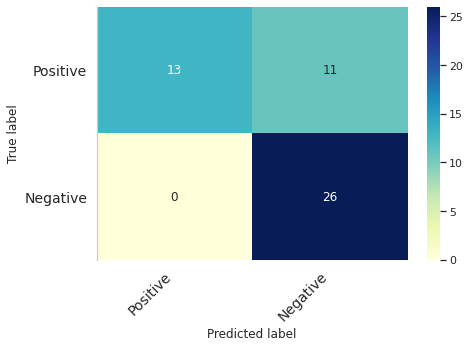

In [116]:
def print_confusion_matrix(confusion_matrix, class_names, figsize=(10, 7), 
                           fontsize=14):
    '''
    Helper function to display the confusion matrix
      :param confusion_matrix: confusion matrix
      :param class_names: class names to display
      :param figsize: figure size
      :param fontsize: figure font size
      :return: the confusion matrix plot
    '''
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)

    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    heatmap.yaxis.set_ticklabels(
        heatmap.yaxis.get_ticklabels(), rotation=0,
        ha='right', fontsize=fontsize
    )
    heatmap.xaxis.set_ticklabels(
        heatmap.xaxis.get_ticklabels(), rotation=45,
        ha='right', fontsize=fontsize
    )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return fig

conf_mx = confusion_matrix(y_test, predictions)

fig = print_confusion_matrix(
    conf_mx, 
    ['Positive', 'Negative'], 
    figsize=(7,5)
)

# Finalize the plot
sns.despine(left=False, bottom=True)
plt.tight_layout(h_pad=2)

# Save the plot
fig.savefig('original_model_confusion_matrix.png', dpi=200)

We notice the overall accuracy of the current model to be of **78%** and that it misclassifies almost half of the *'Positive'* reviews.

### Current model inference time

We can equally register the current model's inference time and compare it with other sentiment analysis models which could represent an improved solution for our task. 

In [16]:
import time

In [17]:
inference_times = []

for i in range(len(X_test)):
  start_time = time.time()
  _ = clf_pipe.predict([X_test[i]])
  stop_time = time.time()
  inference_times.append((stop_time - start_time)*1000)

In [18]:
from statistics import median

In [19]:
median_time = median(inference_times)
print("Inference time: {:.2f}".format(median_time))

Inference time: 0.95


The current model provides a decision on whether a review is positive or negative in **0.95 milliseconds**.

In [20]:
# Register all models' inference time
model_inference = []
model_inference.append(round(median_time, 2))

## CamemBERT fine-tuning

Since our current model's performance is unsatisfactory we will test other solution for our task. One of these is using a pre-trained CamemBERT model and fine-tune it to our test dataset. 

In [21]:
X, y = data_transform(train_data)

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, 
                                                  random_state=42)

Google Colab offers free GPUs and TPUs. Since we'll be training a large neural network it's best to utilize these features.

A GPU can be added by going to the menu and selecting:

`Runtime -> Change runtime type -> Hardware accelerator: GPU`

Then we need to run the following cell to specify the GPU as the device.

In [24]:
import tensorflow as tf
assert tf.__version__ >= "2.0"

In [25]:
# Check that we are running our experiment of GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

The transformer library of Hugging Face contains PyTorch implementation of state-of-the-art CamemBERT and pre-trained model weights.

In [26]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 1.9MB 7.7MB/s 
     |████████████████████████████████| 3.2MB 34.1MB/s 
     |████████████████████████████████| 890kB 50.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=dcaa45341b91bd2be8f4b004ef8ffa9bb2a0676ca6fa680cebf930cb8c76b550
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 7.2MB/s 


In order to apply the pre-trained CamemBERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the CamemBERT tokenizer has a particular way of handling out-of-vocabulary words.

In [27]:
from transformers import AutoTokenizer

In [28]:
tokenizer =  AutoTokenizer.from_pretrained('camembert-base', use_fast=True)

In [29]:
import numpy as np

In [30]:
def encode_reviews(tokenizer, reviews, max_length):
    '''
    Function to encode the reviews with the help of a transformers tokenizer.
      :param tokenizer: tokenizer to use 
      :param reviews: reviews to be encoded
      :param max_length: the maximum lenght defined for the reviews dataset
      :return: a dictionary of a list of token ids to be fed to a model 
              (input_ids) and a list of indices specifying which tokens should 
              be attended to by the model (attention_mask)
    '''
    token_ids = np.zeros(shape=(len(reviews), max_length),
                         dtype=np.int32)
    for i, review in enumerate(reviews):
        encoded = tokenizer.encode(review, max_length=max_length)
        token_ids[i, 0:len(encoded)] = encoded
    attention_mask = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_mask": attention_mask}

In [31]:
all_data = np.concatenate([train_data['comment'].values, 
                           test_data['comment'].values])

# Encode our concatenated data
encoded_data = [tokenizer.encode(sent) for sent in all_data]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_data])
print('Max length: ', max_len)

Max length:  93


In [32]:
MAX_SEQ_LEN = 93

In [33]:
encoded_train = encode_reviews(tokenizer, X_train, MAX_SEQ_LEN)
encoded_valid = encode_reviews(tokenizer, X_val, MAX_SEQ_LEN)
encoded_test = encode_reviews(tokenizer, X_test, MAX_SEQ_LEN)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Furtheron, we import the CamemBERT model and its trained weights. 

In [34]:
from transformers import TFCamembertForSequenceClassification

In [35]:
model = TFCamembertForSequenceClassification.from_pretrained("jplu/tf-camembert-base")

opt = tf.keras.optimizers.Adam(learning_rate=5e-6, epsilon=1e-08)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)    

model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

Some layers of TFCamembertForSequenceClassification were not initialized from the model checkpoint at jplu/tf-camembert-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
model.summary()

Model: "tf_camembert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  110031360 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  592130    
Total params: 110,623,490
Trainable params: 110,623,490
Non-trainable params: 0
_________________________________________________________________


We will define an `EarlyStopping` callback to stop the training once the validation loss starts to increase, thus preventing the model from overfitting. Once the training is stopped, the callback will recover the weights that registered the best performance. 

In [37]:
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='auto', patience=2,
    verbose=1, restore_best_weights=True) 

We can proceed to fine-tuning the CamemBERT model. The training last for 7 epochs and attains an accuracy of 94% on the validation dataset.

In [38]:
history = model.fit(
    encoded_train, y_train, epochs=20, batch_size=4, 
    validation_data=(encoded_valid, y_val), callbacks=[early_stopper], 
    verbose=1)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autog

We save the weights of the fine-tuned model.

In [39]:
model.save_weights('camembert_reviews_weights.hdf5')

### Fine-tuned CamemBERT perfomances

We shall compare the performance of this new model to our current one and verify it the new solution provides a significant improvement to justify the replacement of the current model. 

In [40]:
scores = model.predict(encoded_test)
y_pred = np.argmax(scores[0][:], axis=1)

In [41]:
print("Test Accuracy: {:.2f}".format(metrics.accuracy_score(y_test,
                                                                  y_pred)))
print("Test F1-Score: {:.2f}".format(metrics.f1_score(y_test,
                                                            y_pred)))

Test Accuracy: 0.96
Test F1-Score: 0.96


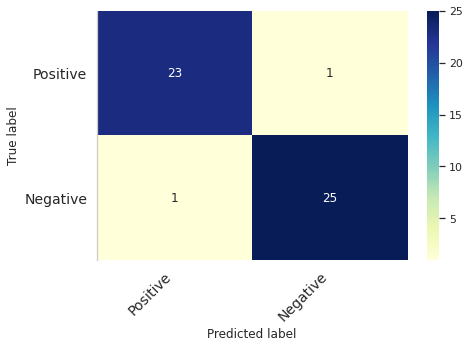

In [115]:
conf_mx_cbert = confusion_matrix(y_test, y_pred)

fig = print_confusion_matrix(
    conf_mx_cbert, 
    ['Positive', 'Negative'], 
    figsize=(7,5)
)

# Finalize the plot
sns.despine(left=False, bottom=True)
plt.tight_layout(h_pad=2)

# Save the plot
fig.savefig('cbert_model_confusion_matrix.png', dpi=200)

Indeed, the fine-tuned CamemBERT model registers a **12% improvement** in accuracy (96%) and only missclassifies one "positive" and one "negative" review. 

### Fine-tunes CamemBERT inference time

In [45]:
inference_times_ft = []

for i in range(len(X_test)):
    start_time = time.time()
    test_input = encode_reviews(tokenizer, [X_test[i]], MAX_SEQ_LEN)
    _ = model.predict(test_input)
    stop_time = time.time()
    
    inference_times_ft.append((stop_time - start_time)*1000)

In [46]:
median_time = median(inference_times_ft)
print("Inference time: ", median_time)

Inference time:  45.93372344970703


However, this new model is taking a longer time to provide the sentiment analysis output: a median time of **45.93 milliseconds** for a review classification to "positive" or "negative". 

In [47]:
# Append model inference time to the list of all models' inference time
model_inference.append(round(median_time, 2))

## CamemBERT trained on movie reviews

[Blard, 2020](https://github.com/TheophileBlard/french-sentiment-analysis-with-bert) equally provides a fine-tuned CamemBERT model on 200,000 reviews from the French movie review website [Allociné.fr](https://www.allocine.fr/). While our task is to classify restaurant reviews, it is interesting to investigate whether a CamemBERT model fine-tuned of movie reviews can 'adapt' to classifying other type of reviews. 

For this, we will dowload the tokenizer and the model and test their performance on our test dataset. 

In [48]:
from transformers import TFAutoModelForSequenceClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("tblard/tf-allocine", use_fast=True)
model = TFAutoModelForSequenceClassification.from_pretrained("tblard/tf-allocine")

nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

All the layers of TFCamembertForSequenceClassification were initialized from the model checkpoint at tblard/tf-allocine.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForSequenceClassification for predictions without further training.


### CamemBERT(Allociné) performances

In [49]:
transf_lern_pred = []

for text in X_test:
  result = nlp(text)
  prediction = result[0]["label"]

  if prediction == "POSITIVE": 
    transf_lern_pred.append(1)
  else:
    transf_lern_pred.append(0)

In [50]:
transf_lern_pred = np.array(transf_lern_pred)

In [51]:
print("Test Accuracy: {:.2f}".format(metrics.accuracy_score(y_test,
                                                                  transf_lern_pred)))
print("Test F1-Score: {:.2f}".format(metrics.f1_score(y_test,
                                                            transf_lern_pred)))

Test Accuracy: 0.98
Test F1-Score: 0.98


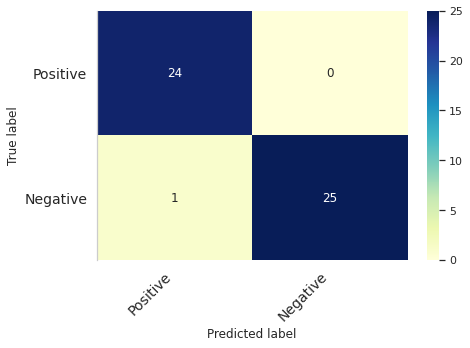

In [114]:
conf_mx_cbert_transf = confusion_matrix(y_test, transf_lern_pred)

fig = print_confusion_matrix(
    conf_mx_cbert_transf, 
    ['Positive', 'Negative'], 
    figsize=(7,5)
)

# Finalize the plot
sns.despine(left=False, bottom=True)
plt.tight_layout(h_pad=2)

# Save the plot
fig.savefig('cbert_transf_model_confusion_matrix.png', dpi=200)

This model succedes in performing a classification of restaurant reviews in our test dataset with **98%** of accuracy. This confirms the transformer models adaptability to different NLP tasks and provides, to date, the best model to integrate in our application. 

### CamemBERT(Allociné) inference time

In [52]:
inference_times_tf = []

for text in X_test:
    start_time = time.time()
    _ = nlp(text)
    stop_time = time.time()
    
    inference_times_tf.append((stop_time - start_time)*1000)

In [53]:
median_time = median(inference_times_tf)
print("Inference time: ", median_time)

Inference time:  322.7154016494751


This comes, however, with a cost which, here, represent the significant increase in model inference time. The CamemBERT by Blard, 2020 provides a classification decision in **322.72 milliseconds**.   

In [57]:
# Append model inference time to the list of all models' inference time
model_inference.append(round(median_time, 2))

Plot and comapre all models' inference time.

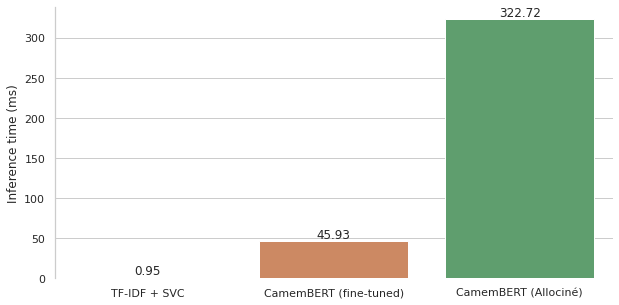

In [117]:
models = ['TF-IDF + SVC', 'CamemBERT (fine-tuned)', 'CamemBERT (Allociné)']

# Set figure size and style
fig = plt.figure(figsize=(10,5))
sns.set(style="whitegrid")

# Plot the inference time list
plot = sns.barplot(x=models, y=model_inference)

# Print the values for each model
for p in plot.patches:
  plot.annotate('{:.02f}'.format(p.get_height()), (p.get_x()+0.4, 
                p.get_height()), ha='center', va='bottom')

# Finalize the plot        
plt.ylabel('Inference time (ms)')
sns.despine(bottom=True)
plt.show()

# Save the plot
fig.savefig('model_inference_time_comaprison.png', dpi=200)

While the long inference time of CamemBERT(Allociné) might represent a hindrance for an on-line classification task or for large amounts of data, for a single-shot classification application this difference in inference time is almost unperceivable to a human.

It, therefore, represents the best solution for our task.